In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import *

import scipy.io # To load the matrix
from pyDOE import lhs # For Latin Hypercube samplig method
import numpy as np

In [2]:
# Model name
model_name = 'burgers_1d_pinn.pt'

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class Net_F(nn.Module):
    def __init__(self, net_u, nu):
        """
        Compute the residuals

        Inputs :
            net_u : 
            nu : 
            device : self explenatory, cuda if possible 
        """
        nn.Module.__init__(self)
        self.net_u = net_u
        self.nu = nu

    def forward(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f

In [4]:
class Net_U(nn.Module):
    def __init__(self,dnn):

        nn.Module.__init__(self)

        self.dnn = dnn

    def forward(self,x,t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

In [5]:
class PINN_loss(nn.Module):
    def __init__(self):

        nn.Module.__init__(self)

    def forward(self,u,u_pred,f_pred):
        loss_u = torch.mean((u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)

        loss = loss_u + loss_f
        return loss, loss_u, loss_f

In [6]:
# # # Known labels dataset
class u_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        super(Dataset, self).__init__()

        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return self.inputs.shape[0]
        
    def __getitem__(self, index):

        # X 
        X = self.inputs[index, :]

        y = self.outputs[index]
        return X, y

# # # Residuals dataset
class f_Dataset(Dataset):
    def __init__(self, inputs):
        super(Dataset, self).__init__()

        self.inputs = inputs

    def __len__(self):
        return self.inputs.shape[0]
        
    def __getitem__(self, index):

        # X 
        X = self.inputs[index, :]

        return X

In [7]:
# # # Parameters
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

# Initial conditions
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))  # x = -1:1, t = 0
uu1 = Exact[0:1,:].T
print('Initial conditions',xx1.shape)

# Boundary conditions
xx2 = np.hstack((X[:,0:1], T[:,0:1]))   # x = -1, t = 0:1
uu2 = Exact[:,0:1]
print('Boundary conditions',xx2.shape)

# Boundary conditions
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # x = 1, t = 0:1
uu3 = Exact[:,-1:]
print('Boundary conditions',xx3.shape)

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)

print('All predictions',X_u_train.shape)

X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

print('All residuals (BC+IC+domain)',X_f_train.shape)

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) # select N_u points from all known values (IC + BC)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

Initial conditions (256, 2)
Boundary conditions (100, 2)
Boundary conditions (100, 2)
All predictions (456, 2)
All residuals (BC+IC+domain) (10456, 2)


## Train with : Adam

In [8]:
f_dataset = f_Dataset(X_f_train)
u_dataset = u_Dataset(X_u_train,u_train)

f_trainloader = DataLoader(f_dataset, batch_size=1000, shuffle=True, num_workers=0)
u_trainloader = DataLoader(u_dataset, batch_size=10, shuffle=True, num_workers=0)

In [9]:
dnn = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
dnn = dnn.to(device)

optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-2)

net_u = Net_U(dnn=dnn)
net_f = Net_F(net_u=net_u,nu=nu)

pinn_loss = PINN_loss()

In [10]:
epoch = 2000

tot_loss = []
tot_loss_u = []
tot_loss_f = []

for i in range(epoch):
    dnn.train()

    epoch_loss = 0
    epoch_loss_u = 0
    epoch_loss_f = 0

    for (X_u, u),(X_f) in zip(u_trainloader, f_trainloader):

        x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)

        u = torch.tensor(u, requires_grad=True).float().to(device)
        
        x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)       

        optimizer.zero_grad()

        preds_u = net_u(x_u,t_u)
        preds_f = net_f(x_f,t_f)

        loss, loss_u, loss_f = pinn_loss(u,preds_u,preds_f)

        loss.backward()

        optimizer.step()

        # Add loss
        epoch_loss += loss
        epoch_loss_u += loss_u
        epoch_loss_f += loss_f

    tot_loss.append(epoch_loss)
    tot_loss_u.append(epoch_loss_u)
    tot_loss_f.append(epoch_loss_f)

    if i % 100 == 0:
        print('Iter %d, Loss: %.3e, Loss_u: %.3e, Loss_f: %.3e' % (i,epoch_loss, epoch_loss_u, epoch_loss_f))

C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended 

In [11]:
# Save model 
PATH = model_name

torch.save(dnn.state_dict(), PATH)

In [12]:
# Load model
PATH = model_name

model_test = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
model_test.load_state_dict(torch.load(PATH))
model_test.eval()

Model(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
  )
  (out): Linear(in_features=20, out_features=1, bias=True)
  (tanh): Tanh()
)

In [13]:
# Predictions
net_u = Net_U(dnn=model_test)
net_f = Net_F(net_u=net_u,nu=nu)

x = torch.tensor(X_star[:, 0:1], requires_grad=True).float()
t = torch.tensor(X_star[:, 1:2], requires_grad=True).float()

u_preds = net_u(x, t)
f_preds = net_f(x, t)

u_preds = u_preds.detach().cpu().numpy()
f_preds = f_preds.detach().cpu().numpy()

In [14]:
# Compute Error
error_u = np.linalg.norm(u_star-u_preds,2)/np.linalg.norm(u_star,2)

print(error_u)

1.0214503941193624


In [15]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [16]:
U_pred = griddata(X_star, u_preds.flatten(), (X, T), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
U_error = griddata(X_star, u_star.flatten()-u_preds.flatten(), (X, T), method='cubic')

In [17]:
Error = np.abs(Exact - U_pred)

In [18]:
def add_colorbar():
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15) 

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

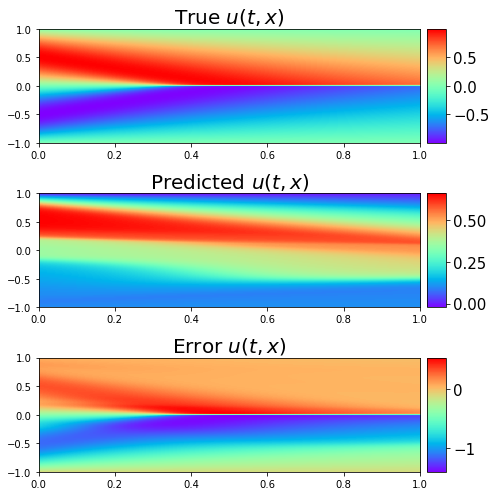

In [20]:
fig = plt.figure(figsize=(7, 7))
ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

h = ax0.imshow(U_star.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax0.set_title('True $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

h = ax1.imshow(U_pred.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax1.set_title('Predicted $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

h = ax2.imshow(U_error.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax2.set_title('Error $u(t,x)$', fontsize = 20)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

plt.tight_layout()

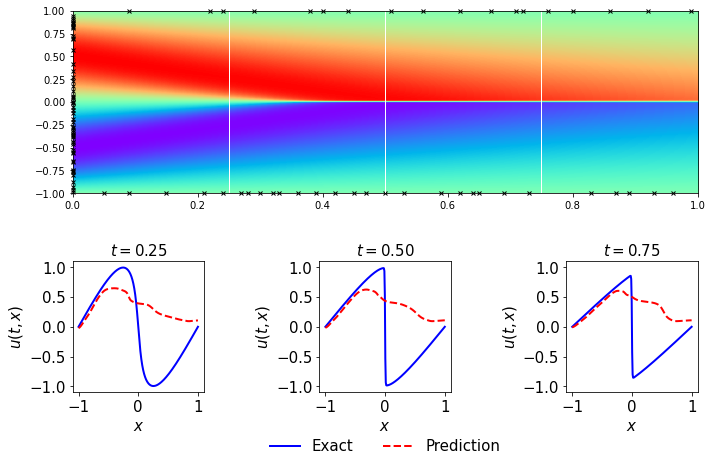

In [21]:
fig = plt.figure(figsize=(10,7))

gs = gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[0, :])

h = ax.imshow(U_star.T,extent=[0, 1, -1, 1], aspect='auto',cmap='rainbow')
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,
    clip_on = False
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax0 = fig.add_subplot(gs[1, 0])
ax1 = fig.add_subplot(gs[1, 1])
ax2 = fig.add_subplot(gs[1, 2])

ax0.set_title('$t = 0.25$', fontsize = 15)
ax0.plot(data['x'].flatten()[:,None],Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax0.plot(data['x'].flatten()[:,None],U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax0.axis('square')

ax1.set_title('$t = 0.50$', fontsize = 15)
ax1.plot(data['x'].flatten()[:,None],Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax1.plot(data['x'].flatten()[:,None],U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax1.axis('square')

ax2.set_title('$t = 0.75$', fontsize = 15)
ax2.plot(data['x'].flatten()[:,None],Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax2.plot(data['x'].flatten()[:,None],U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax2.axis('square')

line = np.linspace(data['x'].flatten()[:,None].min(), data['x'].flatten()[:,None].max(), 2)[:,None]
ax.plot(data['t'].flatten()[:,None][25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(data['t'].flatten()[:,None][75]*np.ones((2,1)), line, 'w-', linewidth = 1)

for ax in [ax0,ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1]) 

ax1.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

plt.tight_layout()

In [22]:
# Analyis : PINN vs Data Driven

# # # Parameters
nu = 0.01/np.pi
noise = 0.0
N_u = 100   

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]  

# Initial conditions
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))  # x = -1:1, t = 0
uu1 = Exact[0:1,:].T

# Boundary conditions
xx2 = np.hstack((X[:,0:1], T[:,0:1]))   # x = -1, t = 0:1
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # x = 1, t = 0:1
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) 
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

lb = X_star.min(0)
ub = X_star.max(0)

# Start for loop 
for N_f in [10,20,50,100,200,500,1000,2000,5000,10000]:

    # Clean Domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))

    print('Total training data',X_u_train.shape[0])
    print('Total residual data',X_f_train.shape[0])

    u_dataset = u_Dataset(X_u_train,u_train)
    f_dataset = f_Dataset(X_f_train)
    u_trainloader = DataLoader(u_dataset, batch_size=int(N_u/10), shuffle=True, num_workers=0)
    f_trainloader = DataLoader(f_dataset, batch_size=int(N_f/10), shuffle=True, num_workers=0)

    dnn = Model(in_size=2,neurons_layer=[20,20,20,20,20,20],out_size=1)
    dnn = dnn.to(device)

    optimizer = torch.optim.Adam(dnn.parameters(), lr=1e-2)

    net_u = Net_U(dnn=dnn)
    net_f = Net_F(net_u=net_u,nu=nu)
    
    pinn_loss = PINN_loss()

    epoch = 2000

    tot_loss = []
    tot_loss_u = []
    tot_loss_f = []

    for i in range(epoch):
        dnn.train()

        epoch_loss = 0
        epoch_loss_u = 0
        epoch_loss_f = 0

        for (X_u, u),(X_f) in zip(u_trainloader, f_trainloader):

            x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
            t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)

            u = torch.tensor(u, requires_grad=True).float().to(device)
        
            x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
            t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)       
            optimizer.zero_grad()

            preds_u = net_u(x_u,t_u)
            preds_f = net_f(x_f,t_f)

            loss, loss_u, loss_f = pinn_loss(u,preds_u,preds_f)

            loss.backward()

            optimizer.step()

            # Add loss
            epoch_loss += loss
            epoch_loss_u += loss_u
            epoch_loss_f += loss_f

        tot_loss.append(epoch_loss)
        tot_loss_u.append(epoch_loss_u)
        tot_loss_f.append(epoch_loss_f)

        if i % 100 == 0:
            print('Iter %d, Loss: %.3e, Loss_u: %.3e, Loss_f: %.3e' % (i,epoch_loss, epoch_loss_u, epoch_loss_f))
    
    PATH = f'burgers_1d_pinn_{N_f}.pt'
    torch.save(dnn.state_dict(), PATH)

Total training data 100
Total residual data 110
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\nilso\anaconda3\envs\TORCH\lib\site-packages\ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor